### Random Forest

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from fastai.learner import load_pickle
import matplotlib.pyplot as plt
from fastai.tabular.all import *
from fastbook import *


In [22]:
def fit_transform_rf(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        n_jobs=-1, 
        random_state=42
    )

    rf.fit(X_train, y_train)

    proba = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)
    return rf, auc, proba

In [23]:

def plot_feature_importance(rf, X, top_k=20):
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top = imp.head(top_k)[::-1]  # invertir para barh ascendente

    plt.figure(figsize=(8, max(4, top_k*0.4)))
    top.plot(kind="barh")
    plt.title(f"Importancias (Random Forest) - Top {top_k}")
    plt.xlabel("Gini importance")
    plt.tight_layout()
    plt.show()

    return imp


In [24]:
# Cargar datos
to = load_pickle('./prework-tabular-object.pkl')
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

# Entrenar y evaluar
rf, auc, proba = fit_transform_rf(xs, y)
print(f"ROC-AUC (validación): {auc:.6f}")

ROC-AUC (validación): 0.736140


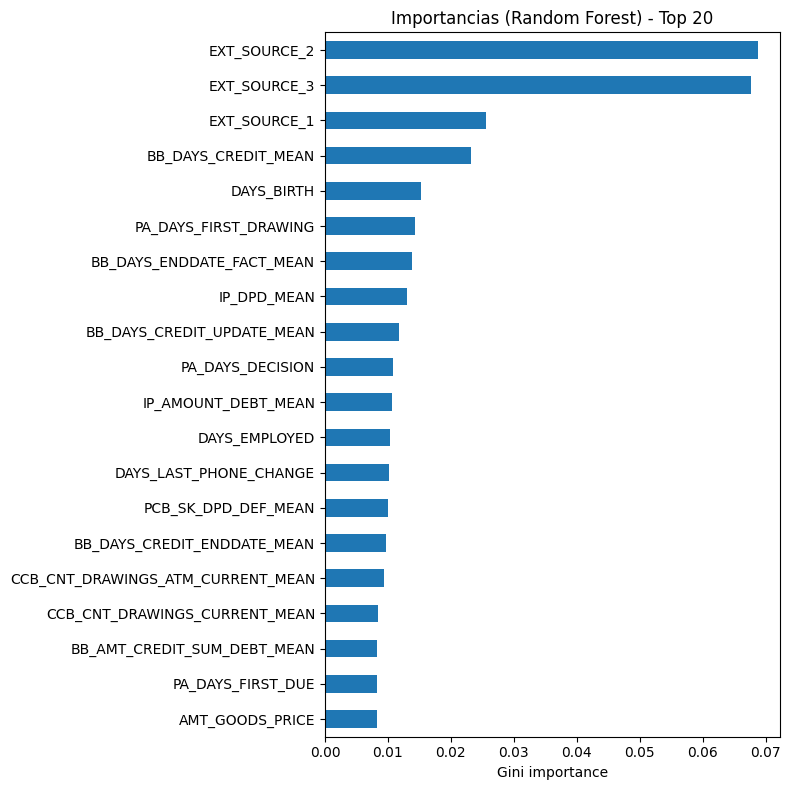

In [25]:
# Calcular y graficar importancias de features
imp = plot_feature_importance(rf, xs, top_k=20)


In [35]:
# Probamos quedarnos con solo features por arriba del threshold de importancia de features
imp = pd.Series(rf.feature_importances_, index=xs.columns).sort_values(ascending=False) # Importancias

# Filtrar features con importancia > threshold
threshold = 0.0075
selected_features = imp[imp > threshold].index
X_reduced = xs[selected_features]

print(f"Total features: {xs.shape[1]}")
print(f"Features retenidas (> {threshold*100:.0f}%): {X_reduced.shape[1]}")
print(f"Features descartadas: {xs.shape[1] - X_reduced.shape[1]}")

# Reentrenar con features reducidas
rf_reduced, auc_reduced, proba_reduced = fit_transform_rf(X_reduced, y)
print(f"ROC-AUC (validación, reduced set): {auc_reduced:.6f}")


Total features: 714
Features retenidas (> 1%): 25
Features descartadas: 689
ROC-AUC (validación, reduced set): 0.737517


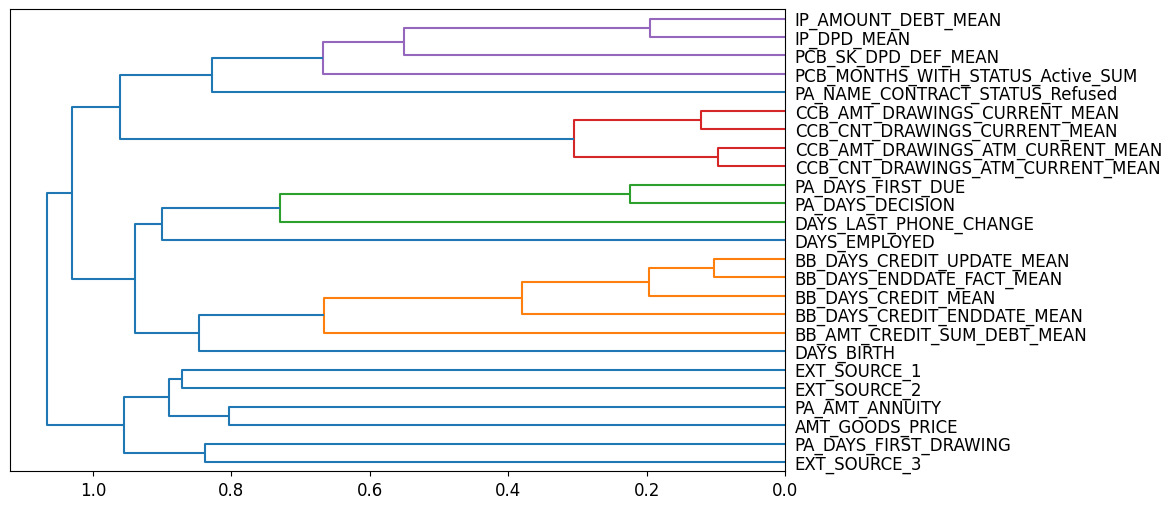

In [ ]:
# Estudio de las columnas de a pares para ir viendo cuales "se parecen" en la información que entregan usando fastai 
# haciendo clustering jerarquico de las columnas que las va agrupando según lo parecidas que son.

cluster_columns(X_reduced)

In [44]:
# Para ver cuales columnas tiramos vamos a proponer como candidatos a los grupos de columnas que se formaron en el gráfico anterior y 
# calcular el oob score al sacar cada columna por separado.
def get_oob(df):
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [45]:
get_oob(X_reduced)

0.07385402687119191

In [ ]:
# # Cdogio a probar si vemos pares de columnas que se parecen
# # {c:get_oob(X_reduced.drop(c, axis=1)) for c in (
#     'columa1', 'columna2', 'etc')}

In [ ]:
# En este punto podemos ver de cada grupito cual fue la columna que menos impacto tuvo en el oob score para ahora descartarlas y ver cómo nos queda el modelo.
# to_drop = ['columna1', 'columna2', 'etc']
# get_oob(X_reduced.drop(to_drop, axis=1))